In [1]:
import matplotlib.pyplot as plt
import numpy as np
from lowEBMs.Packages.Configuration import importer, add_sellersparameters, parameterinterpolatorstepwise, reset
from lowEBMs.Packages.Configuration import import_parallelparameter, allocate_parallelparameter, write_parallelparameter
from lowEBMs.Packages.Variables import variable_importer
from lowEBMs.Packages.RK4 import rk4alg
from lowEBMs.Packages.ModelEquation import model_equation
from lowEBMs.Packages.Variables import Vars,reset, trackerreset, datareset
from lowEBMs.Packages.Functions import plotmeanstd
from lowEBMs import update_plotstyle, moving_average, constants
import builtins
import matplotlib
update_plotstyle()
matplotlib.rcParams['lines.linewidth']=1.1

In [2]:
Lat_10,ZMT_10=np.loadtxt('Data/ERA_ZMT_Mean_10deginterpolated.txt')
Lat_ERA,ZMT_ERA=np.loadtxt('Data/ERA_ZMT_Mean.txt')

In [3]:
def coremodule(config,P0,P_pert,Pmin,Pmax,labels,ZMT,GMT,grid,maxlength,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_paras,gamma0,control,controlconfig):
    from tqdm import tqdm, tnrange
    
    F=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,2*num_paras+1))
    dF=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    P=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    Ptrans=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    gamma=np.zeros(maxlength)
    
    if targetmode=='Single':
        dataout=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,(2*num_paras+1)))
    elif targetmode=='ZMT':
        dataout=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
    elif targetmode=='GMT':
        dataout=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))
    elif targetmode=='Coupled':
        dataout_ZMT=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
        dataout_GMT=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))     
    for i in tnrange(maxlength):
        print('Iteration no.'+str(i))
        if i==0:
            P[i]=P0
            Ptrans[i]=(P0-Pmin)/(Pmax-Pmin)
            Ptrans_pert=Ptrans[i]*P_pert[0]/P0[0]

        if targetmode=='Coupled':
            data_ZMT,data_GMT=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation)
            dataout_ZMT[i]=data_ZMT
            dataout_GMT[i]=data_GMT
        else:
            data=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation)
            dataout[i]=data
            
        if targetmode=='Coupled':
            target_ZMT=target['ZMT']
            target_GMT=target['GMT']
            F_ZMT=target_comparison(data_ZMT,'ZMT',target_ZMT,targetfunction,num_paras,grid)
            F_GMT=target_comparison(data_GMT,'GMT',target_GMT,targetfunction,num_paras,grid)
            F[i]=ratio_ZMT_GMT*F_ZMT+(1-ratio_ZMT_GMT)*F_GMT
        else:
            F[i]=target_comparison(data,targetmode,target,targetfunction,num_paras,grid)

        dF[i]=local_gradient(F[i],Ptrans_pert)
        #dF[i]=local_gradient(F[i],P_pert)
        if i==0:
            gamma[i]=gamma0
        else:
            #gamma[i]=step_weighting(dF[i-1],dF[i],P[i-1],P[i])
            gamma[i]=step_weighting(dF[i-1],dF[i],Ptrans[i-1],Ptrans[i])
            
        if precision_check(dF[0],dF[i],precision):
            print('stop',i)
            P=P[:i]
            Ptrans=Ptrans[:i]
            F=F[:i]
            dF=dF[:i]
            gamma=gamma[:i]
            break
                
        #P_next=new_parameters(P[i],gamma[i],dF[i])        
        Ptrans_next=new_parameters(Ptrans[i],gamma[i],dF[i])

        for k in range(num_paras):
            if Ptrans_next[k]<0:
                Ptrans_next[k]=0.
            if Ptrans_next[k]>1:
                Ptrans_next[k]=1.

        if i<maxlength-1:
            Ptrans[i+1]=Ptrans_next
            P[i+1]=Pmin+Ptrans_next*(Pmax-Pmin)
            print(F[i])
            print(gamma[i])
            print(P[i+1])
            
        if targetmode=='Coupled':
            dataout=[dataout_ZMT,dataout_GMT]
            
    return F, dF, P , Ptrans, gamma, dataout
    
def target_comparison(data,targetmode,target,targetfunction,num_paras,grid):
    F=np.zeros(2*num_paras+1)
    if targetfunction=='LeastSquare':
        if targetmode=='Single':
            F=(np.array(data)-target)**2
        elif targetmode=='ZMT':
            for i in range(len(F)):
                if len(data[i])==len(target):
                    F[i]=np.sum(((data[i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
                elif len(data[i])==len(F):
                    F[i]=np.sum(((data[:,i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
        elif targetmode=='GMT':
            for i in range(len(F)):
                F[i]=np.sum((data[i]-target)**2)

    return F

def local_gradient(F,P_pert):
    dF=np.zeros(len(P_pert))
    for k in range(len(P_pert)):
        dF[k]=(F[2*(k+1)-1]-F[2*(k+1)])/(2*P_pert[k])
    return dF

def step_weighting(dF0,dF1,P0,P1):
    gamma=np.abs(np.dot(P1-P0,dF1-dF0)/np.dot(np.abs(dF1-dF0),np.abs(dF1-dF0)))
    return gamma

def precision_check(dF0,dF,precision):
    dFabs=np.sqrt(np.dot(dF,dF))
    dF0abs=np.sqrt(np.dot(dF0,dF0))
    if dFabs/dF0abs <= precision:
        return True
    
def new_parameters(P,gamma,dF):
    P_next=P-gamma*dF
    return P_next

def run_model(config,P,P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation):
    
    P_config=reshape_parameters(P,P_pert)
    setup={'number_of_parameters': len(P), 'number_of_cycles': 1, 'number_of_parallels': len(P)*2+1}
    
    if targetmode=='Coupled':
        control=True
        
    if control==True:
        variable_importer(controlconfig,initialZMT=True,parallel=True,parallel_config=setup)
        controlconfig=add_parameters(controlconfig,P_config,labels)
        data_CTRL=rk4alg(model_equation,controlconfig['eqparam'],controlconfig['rk4input'],controlconfig['funccomp'],progressbar=True)
        ZMT,GMT=data_CTRL[1][-1],data_CTRL[2][-1]

    variable_importer(config,initialZMT=False,parallel=True,parallel_config=setup)
    config=add_parameters(config,P_config,labels)
    Vars.T,Vars.T_global=ZMT,GMT   
    data=rk4alg(model_equation,config['eqparam'],config['rk4input'],config['funccomp'],progressbar=True)
    
    if targetmode=='Single':
        data_out=data[2][-1]
    elif targetmode=='ZMT':
        dataZMT=data[1][-1]
        for i in range(len(dataZMT)):
            dataZMT[i]=dataZMT[i]+elevation
        data_out=dataZMT
    elif targetmode=='GMT':
        data_out=np.transpose(data[2][:-1]-data[2][0])
    elif targetmode=='Coupled':
        dataZMT=data_CTRL[1][-1]
        for i in range(len(dataZMT)):
            dataZMT[i]=dataZMT[i]+elevation
        dataGMT=np.transpose(data[2][:-1]-data[2][0])
        data_out=[dataZMT,dataGMT]
    return data_out

def reshape_parameters(P,P_pert):
    num_para=len(P)
    P_config=np.reshape(np.zeros(num_para*(2*num_para+1)),(num_para,2*num_para+1))
    for i in range(num_para):
        P_config[i]=np.array([P[i]]*(2*num_para+1))
        P_config[i][i*2+1]=P[i]+P_pert[i]
        P_config[i][i*2+2]=P[i]-P_pert[i]
                      
    return P_config
             
def add_parameters(config,P_config,labels):
    num_para=len(P_config)
    
    for i in range(num_para):
        if labels[i][0][:4]=='func':
            config['funccomp']['funcparam'][labels[i][0]][labels[i][1]]=P_config[i]
        if labels[i][0]=='eqparam':
            config[labels[i][0]][labels[i][1]]=P_config[i]
    return config

In [4]:
#labels=[['eqparam','c_ao'],['func1','a'],['func1','b'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
labels=[['func1','m'],['func1','gamma'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#labels=[['func1','a'],['func1','b']]
P0=np.array([0.5,1.9e-15,1.165,1.165,1.165])
Pmin=np.array([0.4,0.5e-16,0.9,0.9,0.9])
Pmax=np.array([0.6,5e-15,1.3,1.3,1.3])
P_pert=(Pmax-Pmin)/10000
precision=1e-7
maxlength=int(10)
targetmode='ZMT'
target=ZMT_10
targetfunction='LeastSquare'
num_params=5
gamma0=1e-7
ratio_ZMT_GMT=0.5
setup={'number_of_parameters': num_params, 'number_of_cycles': 1, 'number_of_parallels': num_params*2+1}

config_base=importer('Dev_Data/Optimization/Sellers.ini')
variable_importer(config_base,parallel=True,parallel_config=setup)
#print(config_base)
config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)

elevation=-0.0065*np.array(ParasCTRL[1][1])
Zero_ZMT,Zero_GMT=Vars.T,Vars.T_global
grid=Vars.Lat
control=False
controlconfig=0
#print(Vars.T)
#config,P0,P_pert,labels,maxlength,target,function,precision,num_paras,gamma0):
#builtins.number_of_integration=100
F, dF, P, Ptrans, gamma, data=coremodule(config_base,P0,P_pert,Pmin,Pmax,labels,Zero_ZMT,Zero_GMT,grid,\
            maxlength,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_params,gamma0,control,controlconfig)

Loading Configuration from: Dev_Data/Optimization/Sellers.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


Iteration no.0



TypeError: rk4alg() missing 1 required positional argument: 'funccomp'

[1.00000000e-05 8.07724356e-07 1.41040469e-06 1.04709621e-06
 6.58404939e-07 7.18398660e-07 5.29120018e-07 5.30384459e-07
 3.89612197e-06 8.20414639e-04]


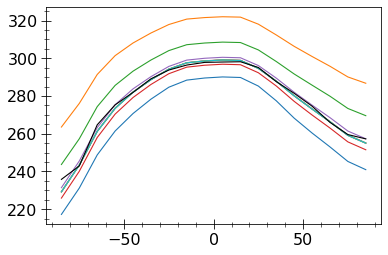

In [32]:
for i in range(10):
    plt.plot(Vars.Lat,data[i][0]+elevation)
#plt.plot(Vars.Lat,data[7][0])
plt.plot(Lat_10,ZMT_10,c='k')
print(gamma)

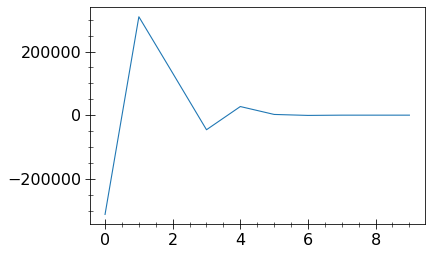

In [37]:
plt.plot(np.arange(10),dF[:,0])

In [7]:
#setup={'number_of_parameters': len(P0), 'number_of_cycles': 1, 'number_of_parallels': len(P0)*2+1}
config_base=importer('Dev_Data/Optimization/Sellers.ini')
variable_importer(config_base,control=True,accuracy=1e-4)
#print(config_base)
config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
#P_config=reshape_parameters(P0,P_pert)

config=add_parameters(config_base,P0,labels)
print(config)
data=rk4alg(model_equation,config['eqparam'],config['rk4input'],config['funccomp'],progressbar=True)

Loading Configuration from: Dev_Data/Optimization/Sellers.ini
Starting controlrun with a temperature accuracy of 0.0001 K on the GMT over 1000 datapoints.
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini
{'eqparam': {'c_ao': 294000000.0}, 'rk4input': {'number_of_integration': 36500, 'stepsize_of_integration': 86400, 'spatial_resolution': 10, 'both_hemispheres': True, 'latitudinal_circle': False, 'latitudinal_belt': True, 'eq_condition': False, 'eq_condition_length': 100, 'eq_condition_amplitude': 0.001, 'data_readout': 5, 'number_of_externals': 1}, 'funccomp': {'funclist': {'func0': <function flux_down.insolation at 0x7f0fb1195c80>, 'func1': <function flux_up.sellers at 0x7f0fb11a9620>, 'func2': <function transfer.sellers at 0x7f0fb11a9730>}, 'funcparam': {'func0': {'q': 1366.14, 'm': 1, 'dq': 0, 'albedo': <function albedo.dynamic_sel at 0x7f0fb11a9400>, 'albedoread': True, 'albedoparam': [array([22

Steady State reached after 78975 steps, within 112.51102447509766 seconds
Finished controlrun over 2116.3698630136987 years. Runtime: 112.58359289169312 s


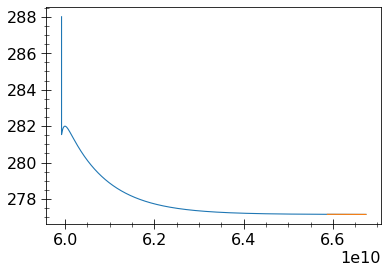

In [11]:
plt.plot(data[0],data[2])
plt.plot(data[0][-10000:],data[2][-10000:])